In [ ]:
# Characterisation can be done by changing settings to qibolab/runcards/tii5q.yml and examples/tii/diagnostics.yml
# These scripts do not save the characterisation results to the runcard

In [1]:
from qibolab.paths import script_folder, qibolab_folder
from qibolab import Platform
from qibolab.calibration import utils
from qibolab.calibration.calibration import Calibration as Diagnostics

diagnostics_settings = script_folder / "diagnostics_5q.yml"
runcard = qibolab_folder / 'runcards' / 'tii5q.yml' 

# Create a platform; connect and configure it
platform = Platform('multiqubit', runcard)
platform.connect()
platform.setup()

# create a diagnostics/calibration object
ds = Diagnostics(platform, diagnostics_settings)

# select the qubit to be characterised
qubit = 1

[Qibo 0.1.7|INFO|2022-08-06 09:26:55]: Using numpy backend on /CPU:0
[Qibo 0.1.7|WARNING|2022-08-06 09:26:55]: numpy backend uses `np.einsum` and supports CPU only. Consider installing the qibojit or qibotf backends for increased performance and to enable GPU acceleration.
[Qibo 0.1.7|INFO|2022-08-06 09:26:56]: Loading platform multiqubit from runcard d:\alvaro\projects\github\qibolab\src\qibolab\runcards\tii5q.yml
[Qibo 0.1.7|INFO|2022-08-06 09:26:56]: Connecting to multiqubit instrument cluster.
[Qibo 0.1.7|INFO|2022-08-06 09:26:58]: Connecting to multiqubit instrument qrm_rf.
[Qibo 0.1.7|INFO|2022-08-06 09:26:58]: Connecting to multiqubit instrument qcm_rf1.
[Qibo 0.1.7|INFO|2022-08-06 09:26:59]: Connecting to multiqubit instrument qcm_rf2.
[Qibo 0.1.7|INFO|2022-08-06 09:27:00]: Connecting to multiqubit instrument qcm_rf3.
[Qibo 0.1.7|INFO|2022-08-06 09:27:01]: Connecting to multiqubit instrument SPI.


Connected to: Qblox SPI Rack (serial:None, firmware:{'device': 'v1.6 - May 10 2019 - mt', 'driver': {'version': '0.6.1', 'build': '20/05/2022-17:29:34', 'hash': 'ef57da54', 'dirty': False}}) in 0.05s


[Qibo 0.1.7|INFO|2022-08-06 09:27:02]: Creating MeasurementControl Calibration


Flux Spectroscopy

In [ ]:
for qubit in range(6):
    for fluxline in range(5):
        ds.run_resonator_spectroscopy_flux(qubit, fluxline)

In [ ]:
for n in range(24, 6*5):
    qubit = n // 5
    fluxline = n % 5
    print(f"scan:{n} qubit: {qubit} fluxline: {fluxline}\n")
    ds.run_resonator_spectroscopy_flux(qubit, fluxline)

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np 
import os
from qibolab.paths import qibolab_folder
files = []
base_folder = qibolab_folder / 'calibration' / 'data'/ 'quantify' / '20220626' # Replace with date!

for experiment_folder in os.listdir(base_folder):
    file_path = base_folder / experiment_folder / 'dataset.hdf5'
    files.append(str(file_path))

l = len(files)
files.sort()

plt.subplots(figsize=(80,60))

plt.rcParams.update({'font.size': 20})
cols = [f'qubit {q}\nGHz' for q in range(5)]
cols.append('qubit 6 (witness)\nGHz')

rows = [f'flux line {fl}\nmA' for fl in range(5)]

for n, file in enumerate(files):
    f = h5py.File(file)
    xlen = f.attrs['xlen']
    ylen = f.attrs['ylen']
    x = (f['x0'][:xlen] + 20e6) / 1e9
    y = f['x1'][:].reshape(xlen, ylen)[:,0] * 1000
    z = np.flipud(f['y0'][:].reshape(f.attrs['ylen'], f.attrs['xlen'])) * 1e6
    qubit = n // 5
    fluxline = n % 5
    ax = plt.subplot(5,6, qubit+1 + fluxline*(6))
    if qubit == 0:
        ax.set_ylabel(rows[fluxline], size='large')
    if fluxline == 0:
        ax.set_title(cols[qubit], rotation=0, size='large', pad = 20)
    plt.imshow(z, extent=[min(x),max(x),min(y),max(y)], aspect="auto")


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.95)
cax = plt.axes([0.85, 0.1, 0.015, 0.85])
plt.colorbar(cax=cax,label='\u03BCV')
plt.suptitle('Resonator Spectroscopy Flux Matrix', fontsize=40, verticalalignment = 'bottom')
plt.savefig('resonator spectroscopy flux matrix.png', bbox_inches='tight')
plt.show()


### Single Qubit Spectroscopies & Rabi

In [24]:
qubit = 2

Resonator Spectroscopy

Starting iterative measurement...
100% completed | elapsed time:      9s | time left:      0s  
100% completed | elapsed time:      9s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     13s | time left:      0s  
100% completed | elapsed time:     13s | time left:      0s  

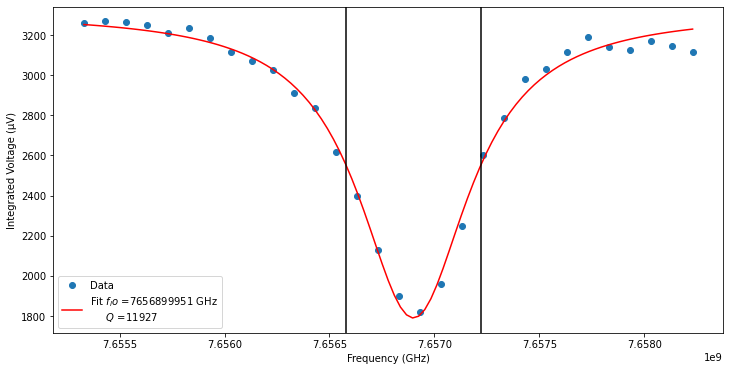


Resonator Frequency = 7676899950


In [23]:
resonator_freq, avg_voltage, peak_voltage, dataset = ds.run_resonator_spectroscopy(qubit)

In [7]:
print(f"Average voltage: {int(avg_voltage)}")
print(f"Peak voltage: {int(peak_voltage)}")
print(f"Resonator frequency: {resonator_freq}")
print(f"LO frequency: {resonator_freq - platform.settings['native_gates']['single_qubit'][qubit]['MZ']['frequency']}")

Average voltage: 2700
Peak voltage: 576
Resonator frequency: 7557713043
LO frequency: 7537713043


Resonator Punchout

In [ ]:
dataset = ds.run_resonator_punchout(qubit)

Resonator Spectroscopy Flux

In [ ]:
dataset = ds.run_resonator_spectroscopy_flux(qubit, fluxline = 2)

Qubit Spectroscopy

In [ ]:
qubit_freq, avg_voltage, peak_voltage, dataset = ds.run_qubit_spectroscopy(qubit)

In [26]:
print(f"Average voltage: {int(avg_voltage)}")
print(f"Peak voltage: {int(peak_voltage)}")
print(f"Qubit frequency: {qubit_freq}")
print(f"LO frequency: {qubit_freq - platform.settings['native_gates']['single_qubit'][qubit]['RX']['frequency']}")

Average voltage: 609
Peak voltage: 0
Qubit frequency: 4688558257
LO frequency: 4888558257


Qubit Spectroscopy Flux with LO

In [ ]:
dataset = ds.run_qubit_spectroscopy_flux(qubit, fluxline = 2)

Rabi Oscillations

In [ ]:
pi_pulse_duration, pi_pulse_amplitude, rabi_oscillations_pi_pulse_peak_ro_voltage, dataset = ds.run_rabi_pulse_length(qubit)

In [3]:
print(f"Pi pulse duration: {pi_pulse_duration}")
print(f"Pi pulse amplitude: {pi_pulse_amplitude}")
print(f"Rabi Oscillation pi pulse peak voltage: {rabi_oscillations_pi_pulse_peak_ro_voltage}")

Pi pulse duration: 14.951596271064481
Pi pulse amplitude: 0.4
Rabi Oscillation pi pulse peak voltage: 636


Rabi Oscillations with varying pulse gain

Starting iterative measurement...
100% completed | elapsed time:     25s | time left:      0s  
100% completed | elapsed time:     25s | time left:      0s  
Pi pulse gain = 0.1694615962603412

Pi pulse amplitude = 0.9

Pi pulse duration = 40

rabi oscillation peak voltage = 582


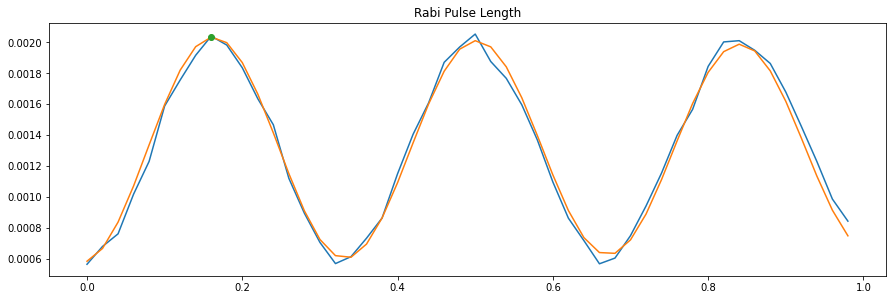

In [34]:
pi_pulse_gain, pi_pulse_amplitude, rabi_oscillations_pi_pulse_peak_voltage, dataset = ds.run_rabi_pulse_gain(qubit)

In [4]:
print(f"Pi pulse gain: {pi_pulse_gain}")
print(f"Pi pulse amplitude: {pi_pulse_amplitude}")
print(f"Rabi Oscillation pi pulse peak voltage: {rabi_oscillations_pi_pulse_peak_ro_voltage}")

Pi pulse gain: 0.3410903702385539
Pi pulse amplitude: 0.9


NameError: name 'rabi_oscillations_pi_pulse_peak_ro_voltage' is not defined

T1

Starting iterative measurement...
100% completed | elapsed time:     54s | time left:      0s  
100% completed | elapsed time:     54s | time left:      0s  

d:\alvaro\projects\github\qibolab\src\qibolab\calibration\fitting.py:197: RuntimeWarning: overflow encountered in exp
  return p[0] - p[1]*np.exp(-1 * x * p[2])



T1 = 26774


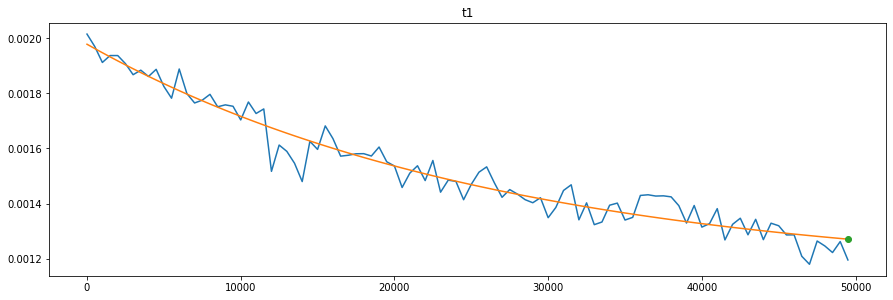

In [2]:
t1, dataset = ds.run_t1(qubit)

Ramsey

In [48]:
delta_frequency, corrected_qubit_frequency, t2, smooth_dataset, dataset = ds.run_ramsey(qubit)

Starting iterative measurement...
 26% completed | elapsed time:     43s | time left:    118s  

[!!!] 1 interruption(s) signaled. Stopping after this iteration/batch.
[Send 4 more interruptions to forcestop (not safe!)].

 27% completed | elapsed time:     43s | time left:    117s  
Interrupt signaled, exiting gracefully...


KeyboardInterrupt: Measurement interrupted

In [8]:
print(f"Delta Frequency: {delta_frequency}")
print(f"Corrected qubit frequency: {corrected_qubit_frequency}")
print(f"T2: {t2}")

Delta Frequency: -424803.7187031799
Corrected qubit frequency: 3843340356
T2: 14121


Ramsey Frequency Detuned

In [ ]:
t2, delta_phys, corrected_qubit_freq, dataset = ds.run_ramsey_frequency_detuned(qubit)

In [14]:
print(f"Delta Frequency: {delta_phys}")
print(f"Corrected qubit frequency: {corrected_qubit_freq}")
lo_qcm_frequency = corrected_qubit_freq + platform.settings['native_gates']['single_qubit'][qubit]['RX']['frequency']
print(f"Corrected out0_lo_freq: {lo_qcm_frequency}")
print(f"T2: {t2}")

Delta Frequency: 0
Corrected qubit frequency: 3843340356
Corrected out0_lo_freq: 3643340356
T2: 6933.310025260633


Flipping

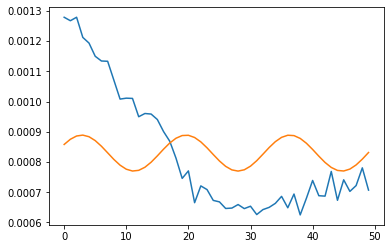

-0.052726657414997186


In [57]:
amplitude_delta = ds.run_flipping(qubit)
print(amplitude_delta)

allXY

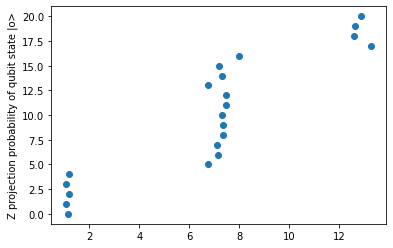

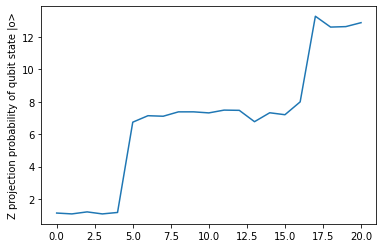

In [3]:
results, gateNumber = ds.run_allXY(qubit)

import matplotlib.pyplot as plt

plt.scatter(results, gateNumber)
plt.ylabel('Z projection probability of qubit state |o>')
plt.show()

plt.plot(results)
plt.ylabel('Z projection probability of qubit state |o>')
plt.show()

#TODO: for consistency move all plotting inside the function

Drag Pulse Beta Parameter Tunning

In [ ]:
beta_optimal = ds.run_drag_pulse_tunning(qubit)

## Spectroscopies Loop

In [ ]:
for qubit in range(5):
    resonator_freq, avg_max_voltage, min_ro_voltage, smooth_dataset, dataset = ds.run_resonator_spectroscopy(qubit)


In [ ]:

for qubit in range(5):
    qubit_freq, max_ro_voltage, smooth_dataset, dataset = ds.run_qubit_spectroscopy(qubit)

In [ ]:
while True:
    resonator_freq, avg_min_voltage, max_ro_voltage, smooth_dataset, dataset = ds.run_resonator_spectroscopy(qubit)

In [ ]:
"""
files = []
files.append('D:\\Alvaro\\Projects\\GitHub\\qibolab\\src\\qibolab\\calibration\\data\quantify\\20220625\\20220625-115433-962-82dd8b-matrix3\\dataset.hdf5')
files.append('D:\\Alvaro\\Projects\\GitHub\\qibolab\\src\\qibolab\\calibration\\data\quantify\\20220625\\20220625-124606-847-d03c47-matrix3\\dataset.hdf5')
files.append('D:\\Alvaro\\Projects\\GitHub\\qibolab\\src\\qibolab\\calibration\\data\quantify\\20220625\\20220625-133808-534-7bdec2-matrix3\\dataset.hdf5')
files.append('D:\\Alvaro\\Projects\\GitHub\\qibolab\\src\\qibolab\\calibration\\data\quantify\\20220625\\20220625-143125-212-35e1bb-matrix3\\dataset.hdf5')
files.append('D:\\Alvaro\\Projects\\GitHub\\qibolab\\src\\qibolab\\calibration\\data\quantify\\20220625\\20220625-152641-950-e4bc4b-matrix3\\dataset.hdf5')
"""